### Customer churn prediction in telecommunication industry

### Problem Statement

Gaining insight into the root causes of customer departures and identifying the most likely timing of such departures can offer valuable insights for enhancing customer retention and making well-informed decisions regarding business strategies. I will employ a structured and systematic approach that is adaptable to a broad spectrum of machine-learning challenges.

In this research, we aim to address the following problem statement:

* How can we predict if an active customer is leaving the company?

We will utilize the Telco Customer Churn dataset . This dataset comprises 3333 records, each with multiple features and a dedicated column indicating whether the customer has experienced churn. 
To gain a deeper understanding of the data, our initial step involves loading it into a pandas dataframe and conducting preliminary exploration using fundamental commands.


In [1]:
##for data manipulation
import pandas as pd
import numpy as np

# for displaying all of the columns in the dataframes
pd.set_option('display.max_columns',None)

# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Import StandardScaler
from sklearn.preprocessing import StandardScaler

#Import VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# for data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#for metrics
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score,\
confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.tree import plot_tree
from sklearn import metrics

In [2]:
telco=pd.read_csv("Churn.csv")

In [3]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   object 
 8   Intl_Plan       3333 non-null   object 
 9   Vmail_Plan      3333 non-null   object 
 10  Day_Calls       3333 non-null   int64  
 11  Day_Charge      3333 non-null   float64
 12  Eve_Calls       3333 non-null   int64  
 13  Eve_Charge      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Calls      3333 non-null   int64  
 17  Intl_Charge     3333 non-null   f

In [4]:
#Check if the target class is imbalanced
telco.Churn.value_counts(normalize=True)

no     0.855086
yes    0.144914
Name: Churn, dtype: float64

Since the target is not balanced ,Accuracy cannot be good measure. Also, since the target minority class class is over 10%, we can don't need to take further action about imbalanced data. 

In [5]:
# Group telco by 'Churn' and compute the mean
telco.groupby(['Churn']).mean()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,Area_Code
Churn,,,,,,,,,,,,,,,,
no,100.793684,8.604561,175.175754,199.043298,200.133193,10.158877,1.449825,100.283158,29.780421,100.038596,16.918909,100.058246,9.006074,4.532982,2.743404,437.074737
yes,102.664596,5.115942,206.914079,212.410145,205.231677,10.700000,2.229814,101.335404,35.175921,100.561077,18.054969,100.399586,9.235528,4.163561,2.889545,437.817805


In [6]:
# Adapt your code to compute the standard deviation
print(telco.groupby(['Churn']).std())

       Account_Length  Vmail_Message   Day_Mins   Eve_Mins  Night_Mins  \
Churn                                                                    
no           39.88235      13.913125  50.181655  50.292175   51.105032   
yes          39.46782      11.860138  68.997792  51.728910   47.132825   

       Intl_Mins  CustServ_Calls  Day_Calls  Day_Charge  Eve_Calls  \
Churn                                                                
no      2.784489        1.163883  19.801157    8.530835  19.958414   
yes     2.793190        1.853275  21.582307   11.729710  19.724711   

       Eve_Charge  Night_Calls  Night_Charge  Intl_Calls  Intl_Charge  \
Churn                                                                   
no       4.274863    19.506246      2.299768    2.441984     0.751784   
yes      4.396762    19.950659      2.121081    2.551575     0.754152   

       Area_Code  
Churn             
no     42.306156  
yes    42.792270  


It appears that Churners tend to place a higher number of customer service calls compared to non-churners(CustServ_Calls)

WWhen handling customer data, geographic regions can significantly influence a customer's decision tocancel or retain their service. Let's see if this is the case here as well

In [7]:
telco.groupby('State')['Churn'].value_counts().sort_values(ascending=False)


State  Churn
WV     no       96
VA     no       72
AL     no       72
WI     no       71
MN     no       69
                ..
AZ     yes       4
LA     yes       4
HI     yes       3
IA     yes       3
AK     yes       3
Name: Churn, Length: 102, dtype: int64

Seems WV has the highest nonchurners compared to AK with the lowest. This is a helpful information for a company!

## Exploring feature distribution


C:\Users\samra\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\samra\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\samra\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\samra\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Suppor

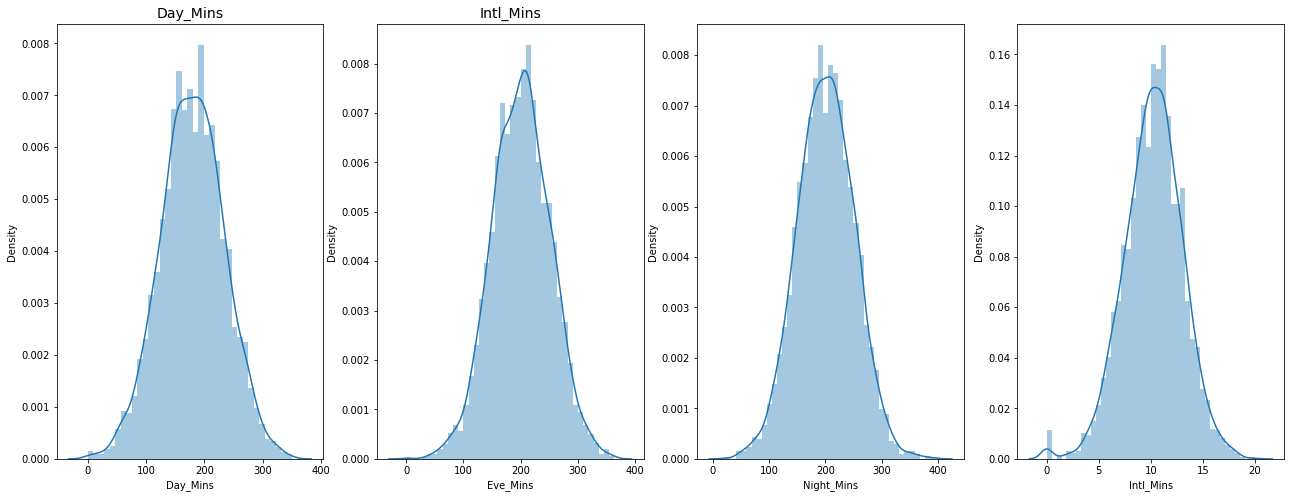

In [8]:
# Set figure and axes
fig, ax = plt.subplots(1, 4, figsize = (22,8))
# Visualize the distribution of 'Day_Mins'
sns.distplot(telco['Day_Mins'],ax=ax[0])
ax[0].set_title('Day_Mins', fontsize='14')
# Visualize the distribution of 'Eve_Mins'
sns.distplot(telco['Eve_Mins'],ax=ax[1])
ax[1].set_title('Eve mins', fontsize='14')
# Visualize the distribution of 'Night_Mins'
sns.distplot(telco['Night_Mins'],ax=ax[2])
ax[1].set_title('Night_Mins', fontsize='14')
# Visualize the distribution of 'Intl_Mins'
sns.distplot(telco['Intl_Mins'],ax=ax[3])
ax[1].set_title('Intl_Mins', fontsize='14')

plt.show()

The normal distribution seems to provide a good approximation for all these features. If this weren't the situation, we'd need to explore the possibility of implementing some form of feature transformation.



The normal distribution provides a good approximation for all these features. If this weren't the situation, we'd need to explore the possibility of implementing some form of feature transformation. 
You've already observed that there isn't a significant distinction in account durations between churners and non-churners. However, there is a notable contrast in the number of customer service calls churners make.
Let's visualize this contrast with a box plot and explore additional intriguing features. Do customers with international plans tend to make more customer service calls? Do they exhibit a higher churn rate? And what about voicemail plans? Let's investigate these questions!

Text(0.5,1,'CustServ_Calls with Intl_Plan')

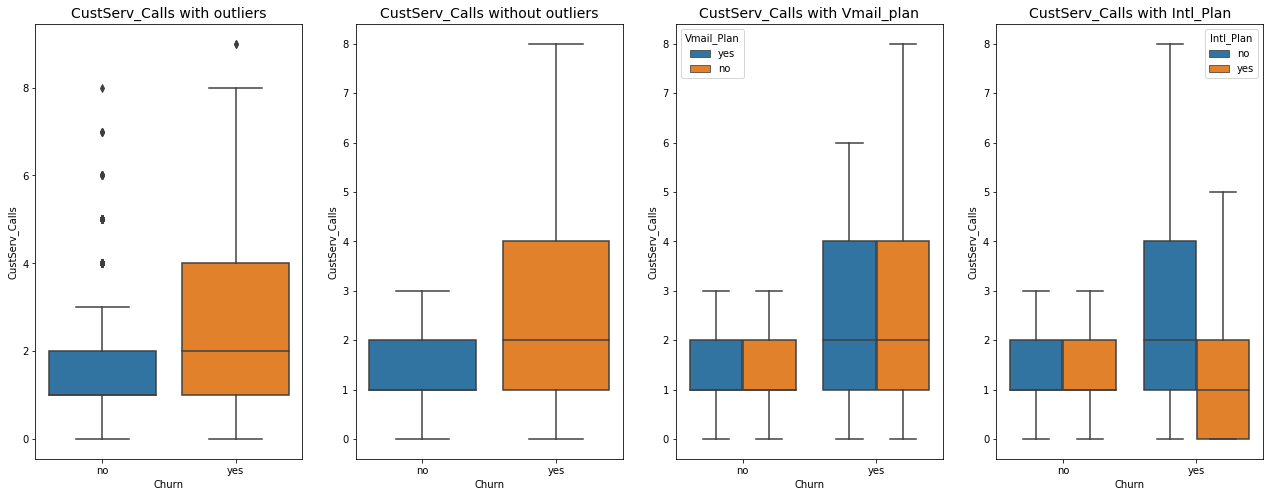

In [9]:
# Set figure and axes
fig, ax = plt.subplots(1, 4, figsize = (22,8))
# Visualize the distribution of 'Day_Mins'
# Create the box plot
sns.boxplot(x = 'Churn',
          y = 'CustServ_Calls',
          data = telco,ax=ax[0])
ax[0].set_title('CustServ_Calls with outliers', fontsize='14')
# Create the box plot for CustServ_Calls without outliers
sns.boxplot(x = 'Churn',
            y = 'CustServ_Calls',
            data = telco,
            sym = "",ax=ax[1])
ax[1].set_title('CustServ_Calls without outliers', fontsize='14')
# Add "Vmail_Plan" as a third variable
sns.boxplot(x = 'Churn',
            y = 'CustServ_Calls',
            data = telco,
            sym = "",
            hue = 'Vmail_Plan',ax=ax[2])
ax[2].set_title('CustServ_Calls with Vmail_plan', fontsize='14')
# Add "Intl_Plan" as a third variable
sns.boxplot(x = 'Churn',
            y = 'CustServ_Calls',
            data = telco,
            sym = "",
            hue = "Intl_Plan",ax=ax[3])
ax[3].set_title('CustServ_Calls with Intl_Plan', fontsize='14')


Some intriguing observations emerge from this data. It appears that churned customers tend to generate a higher volume of customer service calls, except when they also possess an international plan, in which case they leave fewer service calls. Such insights can greatly enhance our comprehension of the factors influencing churn. 

It's time to delve into data preprocessing before moving on to the modeling phase.

### Data Preprocessing

In [10]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   object 
 8   Intl_Plan       3333 non-null   object 
 9   Vmail_Plan      3333 non-null   object 
 10  Day_Calls       3333 non-null   int64  
 11  Day_Charge      3333 non-null   float64
 12  Eve_Calls       3333 non-null   int64  
 13  Eve_Charge      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Calls      3333 non-null   int64  
 17  Intl_Charge     3333 non-null   f

Churn, Vmail_Plan, and Intl_Plan, in particular, are binary features that can easily be converted into 0s and 1s. 

In [11]:
# Replace 'no' with 0 and 'yes' with 1 in 'Vmail_Plan'
telco['Vmail_Plan'] = telco['Vmail_Plan'].replace({'no':0,'yes':1})
telco['Intl_Plan']=telco['Intl_Plan'].replace({'no':0,'yes':1})
# Replace 'no' with 0 and 'yes' with 1 in 'Churn'
telco['Churn'] = telco['Churn'].replace({'no':0,'yes':1})

# Print the results to verify
print(telco['Vmail_Plan'].head())
print(telco['Churn'].head())

0    1
1    1
2    0
3    0
4    0
Name: Vmail_Plan, dtype: int64
0    0
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64


Since we now have many more features in our dataset, we should consider dropping unnecessary ones.

#### Drop columns

In [12]:
#Dropping columns that may not provide any predictive power.We can also bring them backwhen needed
telco_1=telco.drop(["Account_Length","Phone","Area_Code","State"],axis=1)

In [13]:
telco_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Vmail_Message   3333 non-null   int64  
 1   Day_Mins        3333 non-null   float64
 2   Eve_Mins        3333 non-null   float64
 3   Night_Mins      3333 non-null   float64
 4   Intl_Mins       3333 non-null   float64
 5   CustServ_Calls  3333 non-null   int64  
 6   Churn           3333 non-null   int64  
 7   Intl_Plan       3333 non-null   int64  
 8   Vmail_Plan      3333 non-null   int64  
 9   Day_Calls       3333 non-null   int64  
 10  Day_Charge      3333 non-null   float64
 11  Eve_Calls       3333 non-null   int64  
 12  Eve_Charge      3333 non-null   float64
 13  Night_Calls     3333 non-null   int64  
 14  Night_Charge    3333 non-null   float64
 15  Intl_Calls      3333 non-null   int64  
 16  Intl_Charge     3333 non-null   float64
dtypes: float64(8), int64(9)
memory us

Since different features are on different scales, we need to rescale them

#### Missing values

In [14]:
telco_1.isnull().sum()

Vmail_Message     0
Day_Mins          0
Eve_Mins          0
Night_Mins        0
Intl_Mins         0
CustServ_Calls    0
Churn             0
Intl_Plan         0
Vmail_Plan        0
Day_Calls         0
Day_Charge        0
Eve_Calls         0
Eve_Charge        0
Night_Calls       0
Night_Charge      0
Intl_Calls        0
Intl_Charge       0
dtype: int64

#### Feature Engineering

Generating features can be a challenging and time-intensive process that demands expertise. In essence, "applied machine learning" is synonymous with the practice of feature engineering

In [15]:

# Create the new features for avg day, evening and night charges
telco_1['avg_day_cost']=telco_1['Day_Mins']/telco_1['Day_Charge']
telco_1['avg_evening_cost']=telco_1['Eve_Mins']/telco_1['Eve_Charge']
telco_1['avg_night_cost']=telco_1['Night_Mins']/telco_1['Night_Charge']

#creat a feature for avg international charges 
telco_1['avg_intl_charge']=telco_1['Intl_Mins']/telco_1['Intl_Charge']

#Creata feature for a total avg charge per day
telco_1['avg_total_charge']=(telco_1['Day_Mins']+telco_1['Eve_Mins']+telco_1['Night_Mins']+telco_1['Intl_Mins'])/(telco_1['Day_Charge']+telco_1['Eve_Charge']+telco_1['Night_Charge']+telco_1['Intl_Charge'])

# Print the first five rows of 'Avg_Night_Calls'
print(telco_1['avg_total_charge'][:][0:5])

0     9.491795
1    10.553680
2     8.659496
3     8.455090
4     9.829142
Name: avg_total_charge, dtype: float64


In [16]:
sum(telco_1['Day_Mins']+telco_1['Eve_Mins']+telco_1['Night_Mins']+telco_1['Intl_Mins'])/sum((telco_1['Day_Charge']+telco_1['Eve_Charge']+telco_1['Night_Charge']+telco_1['Intl_Charge']))
                                                                                           

9.955714479871254

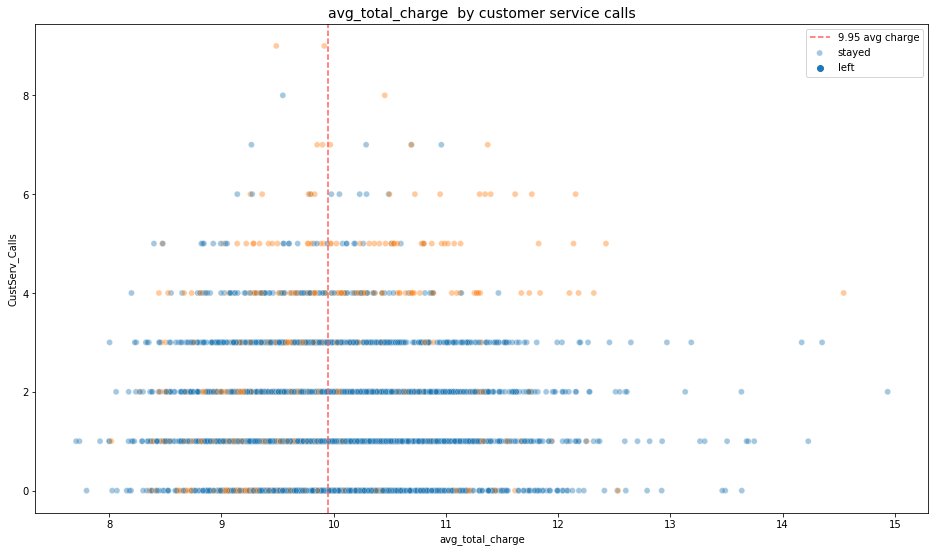

In [17]:
# Create scatterplot of `average_monthly_hours` versus `last_evaluation`
plt.figure(figsize=(16, 9))
sns.scatterplot(data=telco_1, x='avg_total_charge', y='CustServ_Calls', hue='Churn', alpha=0.4)
plt.axvline(x=9.95, color='#ff6361', label='$9.95 total_avg_charge', ls='--')
plt.legend(labels=['9.95 avg charge','stayed', 'left'])
plt.title('avg_total_charge  by customer service calls', fontsize='14');

The scatterplot clearly defines two distinct groups among departing customers:

The first group includes individuals who have been charged more than the average and have made more than four customer service calls.
The second group consists of customers who have paid less than the average and have not made any calls.
A noticeable correlation exists between the average total charge and the number of customer service calls.

In [18]:
#dropping features after feature engineering to avoid having highly corrleated features
#telco_2=telco_1.drop(columns=['Day_Calls','Eve_Calls','Night_Calls','Night_Mins','Eve_Mins','Day_Mins','Day_Charge','Eve_Charge','Night_Charge','Intl_Mins','Intl_Charge'],axis=1)


In [19]:
telco_2=telco_1.copy()

In [20]:
#check if there is any missing data
telco_2.isnull().sum()

Vmail_Message        0
Day_Mins             0
Eve_Mins             0
Night_Mins           0
Intl_Mins            0
CustServ_Calls       0
Churn                0
Intl_Plan            0
Vmail_Plan           0
Day_Calls            0
Day_Charge           0
Eve_Calls            0
Eve_Charge           0
Night_Calls          0
Night_Charge         0
Intl_Calls           0
Intl_Charge          0
avg_day_cost         2
avg_evening_cost     1
avg_night_cost       0
avg_intl_charge     18
avg_total_charge     0
dtype: int64

In [21]:
telco_2.avg_intl_charge=np.where(telco_2.avg_intl_charge.isnull(),0,telco_2.avg_intl_charge)
telco_2.avg_evening_cost=np.where(telco_2.avg_evening_cost.isnull(),0,telco_2.avg_evening_cost)
telco_2.avg_day_cost =np.where(telco_2.avg_day_cost.isnull(),0,telco_2.avg_day_cost)

Since different features are on different scales, we need to rescale them

In [22]:

# Scale telco using StandardScaler
telco_scaled = StandardScaler().fit_transform(telco_2)

# Add column names back for readability
telco_scaled_df = pd.DataFrame(telco_scaled,columns=telco_2.columns)

# Print summary statistics
print(telco_scaled_df.describe()) 

       Vmail_Message      Day_Mins      Eve_Mins    Night_Mins     Intl_Mins  \
count   3.333000e+03  3.333000e+03  3.333000e+03  3.333000e+03  3.333000e+03   
mean    3.832651e-16  7.081711e-16 -1.067919e-16  6.602046e-17 -3.274375e-16   
std     1.000150e+00  1.000150e+00  1.000150e+00  1.000150e+00  1.000150e+00   
min    -5.917599e-01 -3.301096e+00 -3.963622e+00 -3.513648e+00 -3.667413e+00   
25%    -5.917599e-01 -6.624241e-01 -6.780300e-01 -6.698545e-01 -6.223690e-01   
50%    -5.917599e-01 -6.887677e-03  8.276141e-03  6.485803e-03  2.246393e-02   
75%     8.695542e-01  6.725198e-01  6.768330e-01  6.808485e-01  6.672969e-01   
max     3.134591e+00  3.140422e+00  3.209066e+00  3.839081e+00  3.497397e+00   

       CustServ_Calls         Churn     Intl_Plan    Vmail_Plan     Day_Calls  \
count    3.333000e+03  3.333000e+03  3.333000e+03  3.333000e+03  3.333000e+03   
mean     3.275708e-16 -5.176377e-17 -1.021951e-16  6.921823e-17 -2.150828e-16   
std      1.000150e+00  1.000150e+00 

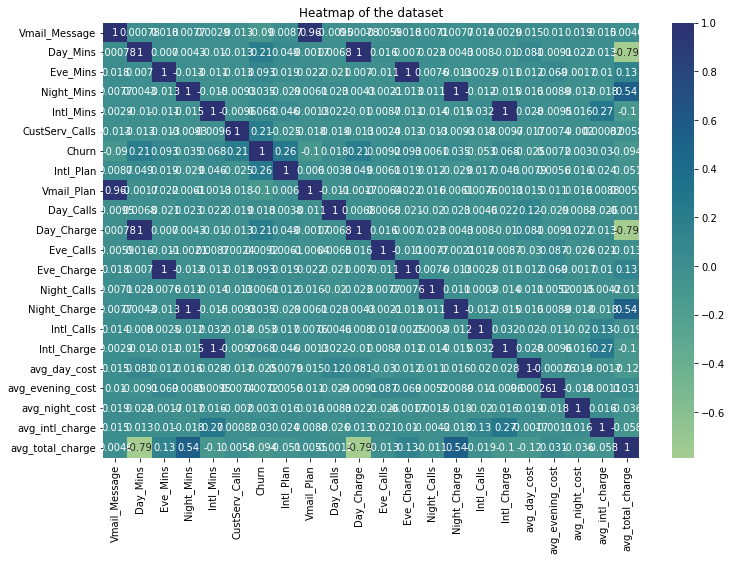

In [23]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(12, 8))
sns.heatmap(telco_scaled_df.corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

Generating features can be a challenging and time-intensive process that demands expertise. In essence, "applied machine learning" is synonymous with feature engineering.
There is a high correlation between vmail _message and vmail_plan. So, we need to remove one of these features to avoid collinearity if we use regression. We use VIF as a measure of collinearity. If the VIF is between 5–10, multicollinearity is likely present, and you should consider dropping the variable.

#### Multicollinearity check

In [24]:

# For each X, calculate VIF and save in dataframe
X1 = telco_scaled_df._get_numeric_data() #drop non-numeric cols
X1.shape
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif["features"] = X1.columns

vif.round(1)

,VIF Factor,features
0,11.9,Vmail_Message
1,10503089.2,Day_Mins
2,2240211.8,Eve_Mins
3,4935304.6,Night_Mins
4,69175.2,Intl_Mins
5,1.1,CustServ_Calls
6,1.3,Churn
7,1.1,Intl_Plan
8,11.9,Vmail_Plan
9,1.0,Day_Calls


Since some features exhibit high correlations, we should either eliminate these features or employ algorithms unaffected by multicollinearity. Tree-based models are not sensitive to multicollinearity, so we opt for these models.Also, we don't need rescaling.

In [25]:
# Create feature variable
#X = telco_scaled_df.drop(['Churn'],axis=1)
X=telco_2.drop(['Churn'],axis=1)
# Create target variable
y = telco_2['Churn']

# Create training and testing sets
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [26]:
#check the lengths of X_train and X_test to see how many records are in each se
print(X_train.shape, X_test.shape,y_train.shape,y_test.shape)

(2333, 21) (1000, 21) (2333,) (1000,)


In [27]:
y_test.value_counts()

0    836
1    164
Name: Churn, dtype: int64

### Modeling Approach A: Tree-based Model

In [28]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4,5,6,7,8,None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='f1')

In [29]:
%%time
#Fit the decision tree model to the training data.
tree1.fit(X_train, y_train)

Wall time: 4.08 s


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6, 7, 8, None],
                         'min_samples_leaf': [2, 5, 1],
          

In [30]:
# Check best parameters
tree1.best_params_

{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [31]:
#Identify the best AUC score achieved by the decision tree model on the training set.
# Check best AUC score on CV
tree1.best_score_

0.7660910233479963

Next, you can write a function that will help you extract all the scores from the grid search.

In [32]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                        'F1': f1,
                        'Recall': recall,
                        'Precision': precision,
                        'Accuracy': accuracy
                        },
                        ignore_index=True
                       )
  
    return table

In [33]:
#Use the function “make_results”, to get all the scores from grid search.
tree1_cv_results=make_results('Decision tree cv',tree1)
tree1_cv_results

,Accuracy,F1,Model,Precision,Recall
0,0.942995,0.766091,Decision tree cv,0.865292,0.689992


### Model Approach B Random forest 
Construct a random forest model and set up a cross-validated grid search to exhaustively search for the best model parameters.

In [34]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
'''
n_estimators:Number of tree
max_features: NUmber of features for best split
max_depth: Max depth of tree
min_sample_splits: Minimum samples to split node
'''    
cv_params = {'max_depth': [3,4,5,6,7,8,None], 
             'max_features': ['auto', 'sqrt', 'log2'],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500], #could add np.arange(10,300)
             "criterion": ["gini", "entropy"]
             
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

Fit the random forest model to the training data.

In [35]:
%%time
rf1.fit(X_train, y_train) # --> Wall time: ~10min

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
C:\Users\samra\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:

Wall time: 53min 56s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
        

In [36]:
#Identify the optimal values for the parameters of the random forest model.
# Check best f1 score on CV
print(rf1.best_score_)
print(rf1.best_params_)



0.7777274226179336
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}


Collect the evaluation scores on the training set for the decision tree and random forest models.

In [37]:
### Get all CV scores
rf1_cv_results = make_results('random forest cv',rf1)

print(rf1_cv_results)

   Accuracy        F1             Model  Precision    Recall
0  0.948566  0.777727  random forest cv   0.946365  0.661669


### Model Approach C XGBoost

In [38]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0) 

cv_params = {'max_depth': [4,5,6,7,8,None], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [300,500]
             }    

scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5,refit='f1')


In [39]:
%%time
xgb1.fit(X_train, y_train)

[16:47:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\samra\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:47:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:47:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:48:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:48:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:48:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:48:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:49:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:49:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:49:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:50:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:50:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:50:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:51:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:51:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:51:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:52:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:52:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:52:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:53:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:53:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:53:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:53:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:53:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:54:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:54:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:58:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:58:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_c...
                                     tree_method=None, use_label_encoder=True,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                     

In [40]:
#Identify the optimal values for the parameters of the random forest model.
print(xgb1.best_score_)
print(xgb1.best_params_)
pd.DataFrame.from_dict(xgb1.best_params_,orient='index')

0.8351778999678778
{'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}


,0
learning_rate,0.2
max_depth,5.0
min_child_weight,1.0
n_estimators,300.0


In [41]:
### Get all CV scores
xgb1_cv_results = make_results('xgboost cv', xgb1)
print("xgboost cv_results:\n ",xgb1_cv_results)
print("treecv_results:\n",tree1_cv_results)
print("random forest cv_results:\n ",rf1_cv_results)

xgboost cv_results:
     Accuracy        F1       Model  Precision    Recall
0  0.958857  0.835178  xgboost cv   0.924146  0.761954
treecv_results:
    Accuracy        F1             Model  Precision    Recall
0  0.942995  0.766091  Decision tree cv   0.865292  0.689992
random forest cv_results:
     Accuracy        F1             Model  Precision    Recall
0  0.948566  0.777727  random forest cv   0.946365  0.661669


The assessment metrics for the xgboost model outperform those of the decision tree and random forest. It's time to assess the final model's performance on the test set.

In [51]:
rf_cv_predicts=rf1.predict(X_test)
print('F1 score final rf model: ', f1_score(y_test, rf_cv_predicts))
print('Recall score final rf model: ', recall_score(y_test, rf_cv_predicts))
print('Precision score final rf model: ', precision_score(y_test, rf_cv_predicts))
print('Accuracy score final rf model: ', accuracy_score(y_test, rf_cv_predicts))
print('Area under the curve :',roc_auc_score(y_test, rf_cv_predicts))

F1 score final rf model:  0.7927272727272726
Recall score final rf model:  0.6646341463414634
Precision score final rf model:  0.9819819819819819
Accuracy score final rf model:  0.943
Area under the curve : 0.8311209009219279


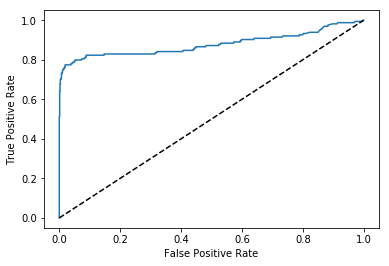

In [43]:
y_pred_prob_rf1=rf1.predict_proba(X_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_pred_prob_rf1)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1],[0,1],"k--")
plt.show()

In [44]:
xgb_cv_preds = xgb1.predict(X_test)
print('F1 score final XGB model: ', f1_score(y_test, xgb_cv_preds))
print('Recall score final XGB model: ', recall_score(y_test, xgb_cv_preds))
print('Precision score final XGB model: ', precision_score(y_test, xgb_cv_preds))
print('Accuracy score final XGB model: ', accuracy_score(y_test, xgb_cv_preds))
print('Area under the curve :',roc_auc_score(y_test, xgb_cv_preds))


F1 score final XGB model:  0.8194444444444444
Recall score final XGB model:  0.7195121951219512
Precision score final XGB model:  0.9516129032258065
Accuracy score final XGB model:  0.948
Area under the curve : 0.8561675808145641


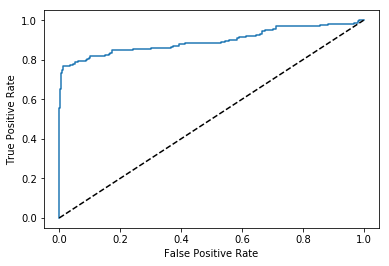

In [45]:
y_pred_prob=xgb1.predict_proba(X_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_pred_prob)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1],[0,1],"k--")
plt.show()

Typically, performance on test data is a little worse than on validation data. Interestingly xgboost perform better.Let's check our confusion matrix.

In [46]:
# Create helper function to plot confusion matrix
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
    labels=['not churned','churned']
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=labels)
  
    disp.plot()
    plt.show()


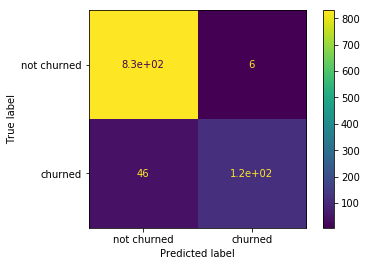

In [47]:
conf_matrix_plot(xgb1, X_test, y_test)


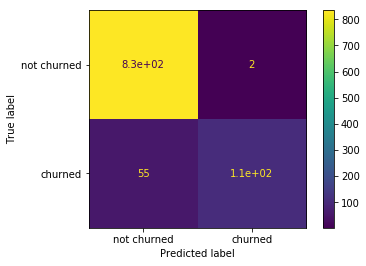

In [48]:
conf_matrix_plot(rf1, X_test, y_test)

Xgboost is slightly better than Random Forest, especially when predicting if customers are not churning. This means customers may be identified as at risk of not leaving the company when that's not the case.


Out of the 1000 individuals in our test dataset, 164 customers decided to leave the company. Our model successfully identified 110 of these departing customers. The confusion matrix reveals that when the model errs, it predominantly commits Type II errors, indicating it often fails to predict a customer's departure (false negatives). On the other hand, it makes fewer Type I errors, which are false positives.

The acceptability of these results hinges on the balance between the costs associated with measures taken to prevent customer churn and the value of retaining those customers. Company leaders may decide that they prefer more true positives, even at the expense of capturing more false positives. In such cases, optimizing the model based on F1 scores may be inadequate, and another evaluation metric may take precedence.

One way to adjust decision-making without retraining the model is by modifying the threshold at which the model predicts a positive response. By default, the model labels a customer as churned if the probability is ≥ 0.50. However, this threshold can be adjusted. For instance, setting it at 0.25 would label customers with predicted probabilities ≥ 0.25 as churned and those with < 0.25 as not churned. This would increase recall but reduce accuracy.

In any case, it's evident that our model benefits the company. Consider the scenario where decision-makers took no action. In that case, they would expect to lose 110 customers. Alternatively, they could incentivize all 1000 customers to stay, incurring a substantial cost. Our model, however, efficiently identifies customers likely to leave, offering a cost-effective approach by targeting true responders and saving the company from unnecessary expenses.

### Feature importance

The XGBoost library has a function called plot_importance, which we imported at the beginning of this notebook. This let's us check the features selected by the model as the most predictive. We can create a plot by calling this function and passing to it the best estimator from our grid search.


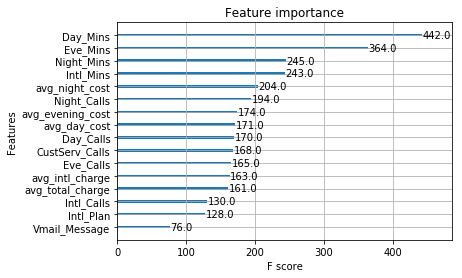

In [49]:
plot_importance(xgb1.best_estimator_);

This reveals that our model's top four crucial features are Day_Mins, Eve_Min, and Averga night cost. This information is highly valuable.
In a comprehensive project, we would thoroughly investigate these features to understand how and why they impact churn.
Moreover, revisiting the data and append the model predictions and state to each sample is advisable. This would allow us to assess how evenly the model distributes its errors across various reported gender identities.